# How to display an image with scientifically meaningful axes in Python



## Setup
Import the necessary libraries

In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

Explicitly define a publicly accessible path to the data files so that this notebook will be portable.

In [2]:
data_path = "https://github.com/dawg-at-irya/fits-image-axes-talk/raw/main/data/"

## Case with an implicit pixel-to-world transformation

We will use a two dimensional image from a numerical simulation, which we load from a FITS file. But this image data might come from anywhere. 



In [3]:
hdulist = fits.open(data_path + "large-image-no-wcs.fits")
hdulist.info()

Filename: /root/.astropy/cache/download/url/0969bc74e9741a4ccd88ddc335594ae0/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (512, 512)   float32   


The image is 512 by 512 pixels

In [4]:
im = hdulist[0].data

We can display the image with matplotlib's `imshow`, which by default uses pixel units.  

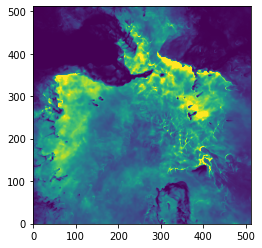

In [5]:
fig, ax = plt.subplots()
ax.imshow(im, origin="lower", vmax=2e6)
# Note that we use origin="lower" so the image is not inverted
...;

However, we want to show the axes in physical length coordinates. We have the following tacit knowledge:

1.   The simulation represents a box of side 4 parsec
2.   The origin is in the center of the box


### Using the `extent` parameter

For a simple case like this, we can add the keyword `extent=[left, right, bottom, top]`. 

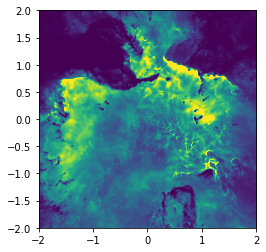

In [6]:
width, height = 4.0, 4.0
left, right = -width/2, width/2
bottom, top = -height/2, height/2
fig, ax = plt.subplots()
ax.imshow(im, extent=[left, right, bottom, top], origin="lower", vmax=2e6)
...;

The first time I tried this, I was worried that there might be a subtle bug related to the difference between the pixel centers and the pixel edges. But, it turns out that it really is this simple!

In order to be able to clearly see the individual pixels, we can try the technique with a very small image, such as a 4x4 checkerboard, so each pixel is of size 1 parsec. We use the same value for `extent` as above.

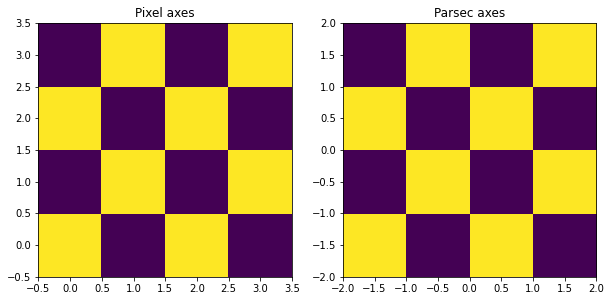

In [15]:
# Make a 4x4 checkerboard image
im2 = np.array([[1, 0]*2, [0, 1]*2]*2)

fig, (ax_a, ax_b) = plt.subplots(1, 2, figsize=(10, 5))
ax_a.imshow(im2, origin="lower")
ax_a.set_title("Pixel axes")
ax_b.imshow(im2, extent=[left, right, bottom, top], origin="lower")
ax_b.set_title("Parsec axes")
...;

We can see that the outer cell edges have *pixel* coordinates that are half integers, since it is the cell centers that have integer coordinates.  

With the parsec coordinates, on the other hand, the outer edges are at a whole number of parsecs, which is exactly what we wanted.

### Using the WCS transformation from pixels to world coordinates

A more flexible approach is to use `astropy.visualization.wcsaxes`.  Usually, there is no need to call this library directly. Instead, we pass a `astropy.wcs.WCS()` object to matplotlib, and everything else happens by magic!

***Show slides that explain what WCS means***

In [16]:
from astropy.wcs import WCS

One of the most common uses of this technique is for celestial coordinates (e.g., RA and Dec) that we get from the header of a FITS file.  However, in this case the FITS header is not of any use, as we will see:

In [18]:
w = WCS(hdulist[0])
w

WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 512  512

So, this header is just the identity transformation. It transforms pixels to ... pixels.

But we can edit it by hand, so that it corresponds to our 4 pc box:

1. We set the size of the pixels in parsec as `cdelt`
2. We set the reference pixel as `crpix`. We are not changing `crval` so this corresponds to the origin. We saw above that the origin is at a pixel corner if we have an even number of pixels.  Also, note that FITS convention is for 1-based indexing, rather than 0-based as in Python.
3. We can also set the units of the axes as `cunit`



In [19]:
nx, ny = im.shape
w.wcs.cdelt = width / nx, height / ny
w.wcs.crpix = (nx + 1) / 2, (ny + 1) / 2
w.wcs.cunit = "pc", "pc"
w

WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 256.5  256.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.0078125  0.0078125  
NAXIS : 512  512

We can now use this transformation as the `projection` parameter when we create an `axes` in matplotlib. 

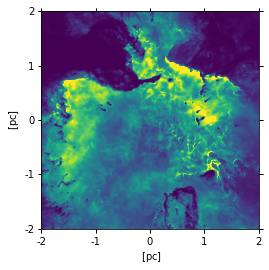

In [20]:
(   # Example of "chaining" style
    plt
    .figure()
    .add_subplot(projection=w)
    .imshow(im, vmax=2e6)
    # This is all a single expression 
);

So this looks very similar to the previous version with `extent`, except that now the units are labelled on the axes. Note that there is no longer any need to specify `origin="lower"`.

It might seem that we have complicated our life for very little gain. However, there are advantages to doing it this way, even in simple cases like this.  For instance, we can take a slice of the full image if we want to zoom in on a particular region.  By applying the same slice to the WCS object, we can maintain consistency in the axis units:

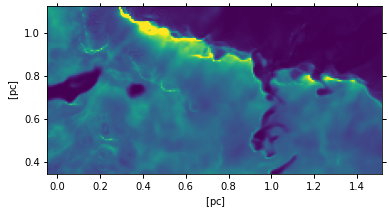

In [29]:
# The following is equivalent to [300:400, 250:450]
window = slice(300, 400), slice(250, 450)
fig, ax = plt.subplots(
    # We cannot pass `projection` directly to .subplots(), 
    # instead we must do this:
    subplot_kw=dict(projection=w.slice(window)),
)
ax.imshow(im[window], vmax=4e6)
...;

Also, we can use world coordinates instead of pixel coordinates in other matplotlib functions by specifying the correct transformation. 

Here is an example of using `scatter` to plot some symbols on top of the image in parsec coordinates. 

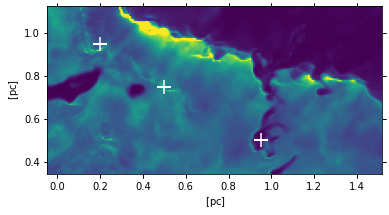

In [28]:
fig, ax = plt.subplots(
    subplot_kw=dict(projection=w.slice(window)),
)
ax.imshow(im[window], vmax=4e6)
ax.scatter(
    x=[0.5, 0.2, 0.95], 
    y=[0.75, 0.95, 0.5], 
    marker="+", c="w", s=200,
    transform=ax.get_transform('world'),
    )
...;

We can us the same technique to plot contours on top of the image. 

## Advanced topics (for another talk!)

1. Non-linear transformations. E.g., geometric distorsion, wide-angle sky projections, healpix.
2. Rotated pixel axes.
3. Combining elements with different WCS transformations in the same plot
4. Re-projecting to a common grid to avoid having to deal with 2 or 3

